# Project Human Language Technology - OffensEval2019
# Task 1
## DistilBERT Base
This notebook will explore a model for competition "OffensEval 2019: Identifying and Categorizing Offensive Language in Social Media" using DistilBERT Base. \
DistilBERT Base is a distilled version of the __BERT Base__ model. \
Matricola: 505252 Michele Morisco

In [1]:
import sys
sys.path.insert(1, '../input/hlt-data/Library/')
dataset_path = '../input/olid-dataset/'
glove_path = '../input/glovetwitter27b100dtxt'

In [2]:
#!pip install pytorch-pretrained-bert pytorch-nlp
!pip install emoji --upgrade
!pip install wordsegment
!pip install transformers 
!pip install ekphrasis
!pip install inflect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 443.9 kB/s eta 0:00:00a 0:00:01
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=67c5782fb9ff9dab74c9ba0b4d5a33a8618bf7964a284f2070941c9906e1aa55
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji
  Attempting uninstall: emoji
    Found existing installation: emoji 2.0.0
    Uninstalling emoji-2.0.0:
      Successfully uninstalled emoji-2.0.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.8/83.8 kB 282.9 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 1.0 MB/s eta 0:00:00a 0:00:01


In [3]:
from PreProcessing import load_dataset
from DistilBERTBase import run_with_kfold, evaluateFinal
from AnalysisGraph import show_confusion_matrix, show_report, showWrongPredictions

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...


In [4]:
import string
string.punctuation
import csv
import pandas as pd
import numpy as np

from transformers import DistilBertForSequenceClassification, DistilBertConfig, DistilBertModel, DistilBertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score
import torch
from torch import tensor
import torch.nn as nn
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import random

#% matplotlib inline

#Random seed initialization for replicability of results
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

import warnings
warnings.filterwarnings("ignore")

In [5]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))
    !nvidia-smi
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB
Thu Oct 13 10:55:03 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    25W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                        

In [6]:
#SET THE PARAMETERS FOR TRAINING 
H_PARAMETERS = {'model_name': 'distilbert-base-uncased', 'unit_layers' : [768, 64, 32, 2], 'dropout': 0.5, 'folds' : 4, 'batch_size': 32, 
                'warmup_proportion' : 0.1, 'learning_rate': 2e-6, 'loss' : nn.CrossEntropyLoss(), 'num_epochs': 5, 'device' : device}

In [7]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [8]:
#dataset = open("OLID/olid-training-v1.0.tsv")
data, label = load_dataset(dataset_path = dataset_path)

data.subtask_a.value_counts()

Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading english - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_1grams.txt
Reading english - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/english/counts_2grams.txt
Reading english - 1grams ...
user canada need another cuck already enough looney leave liberals fking great country qp roof trudeau must go


NOT    8840
OFF    4400
Name: subtask_a, dtype: int64

In [9]:
data.tweet.sample(20)

12823                     user good antifa violent fascism
12290    user de create slowly stealthily since conserv...
8474     christian kabasele reveal secrets behind watfo...
4676     user oppose neutral jurist sit scotus weigh me...
397      user wonder apologize diamond silk call minstr...
10957    user know canada want seem enough problems lib...
3311                                        user love maga
12936    user agree still conservatives heart may hate ...
8575                         play water slider summer http
4392     kyky u love u anfield putain la cliiimmmm liv psg
7673     user compromise active investigation sound lik...
12966    fill sky chemicals frequencies ido consent con...
12215    love one another starlight darkness surround m...
5480     verge collapse break wave cannot explain whole...
3535                user hair polyester fibers yoda puppet
4425                           user first regression laugh
5523     user well brandon conservatives get elect red .

In [10]:
X_train = list(data.tweet.values)

In [11]:
MAX_SEQ_LENGTH = 64

tokenizer = DistilBertTokenizer.from_pretrained(H_PARAMETERS['model_name'], do_lower_case=True)
sentences = data.tweet.values
tokens = tokenizer(X_train, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_train = torch.tensor(tokens['input_ids'])
attention_masks_train  = torch.tensor(tokens['attention_mask'])

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

In [12]:
print('Original: ', sentences[0])
print('Token IDs:', input_ids_train[0])

Original:  user ask native americans take
Token IDs: tensor([ 101, 5310, 3198, 3128, 4841, 2202,  102,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0])


In [13]:
loss_fn = nn.CrossEntropyLoss()

In [14]:
test_data, label_test = load_dataset(dataset_path = dataset_path, dataset='testset-levela.tsv', dataset_label='labels-levela.csv')
X_test = list(test_data.tweet.values)

Reading english - 1grams ...
Reading english - 2grams ...
Reading english - 1grams ...
bigg boss tamil janani task go first final listclapping hand clap hand clap hand clap hand


In [15]:
tokens = tokenizer(X_test, padding=True, truncation=True, max_length=MAX_SEQ_LENGTH)

# Create input ids
input_ids = []
# Create attention masks
attention_masks = []

input_ids_test = torch.tensor(tokens['input_ids'])
attention_masks_test  = torch.tensor(tokens['attention_mask'])

test_dataset = TensorDataset(input_ids_test, attention_masks_test, torch.tensor(label_test))
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=len(test_dataset))

Downloading:   0%|          | 0.00/256M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.684444   |   0.49    |     -      |     -     |     -     |   2.93   
   1    |   40    |   0.679228   |   0.48    |     -      |     -     |     -     |   2.09   
   1    |   60    |   0.671295   |   0.45    |     -      |     -     |     -     |   2.09   
   1    |   80    |   0.669848   |   0.43    |     -      |     -     |     -     |   2.10   
   1    |   100   |   0.661248   |   0.41    |     -      |     -     |     -     |   2.09   
   1    |   120   |   0.672647 

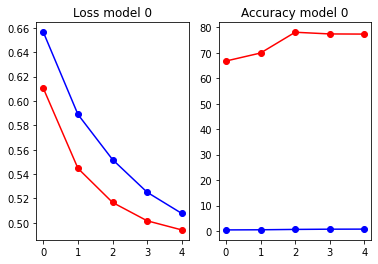

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.649127   |   0.41    |     -      |     -     |     -     |   2.20   
   1    |   40    |   0.652581   |   0.40    |     -      |     -     |     -     |   2.10   
   1    |   60    |   0.646311   |   0.41    |     -      |     -     |     -     |   2.09   
   1    |   80    |   0.666567   |   0.38    |     -      |     -     |     -     |   2.08   
   1    |   100   |   0.642969   |   0.42    |     -      |     -     |     -     |   2.09   
   1    |   120   |   0.640237 

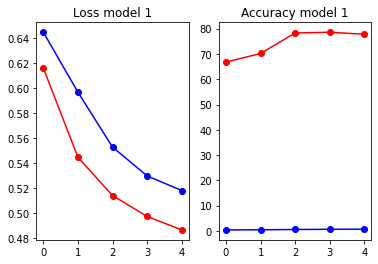

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.730666   |   0.33    |     -      |     -     |     -     |   2.20   
   1    |   40    |   0.719972   |   0.34    |     -      |     -     |     -     |   2.09   
   1    |   60    |   0.714993   |   0.40    |     -      |     -     |     -     |   2.08   
   1    |   80    |   0.709202   |   0.45    |     -      |     -     |     -     |   2.09   
   1    |   100   |   0.701358   |   0.46    |     -      |     -     |     -     |   2.09   
   1    |   120   |   0.694686 

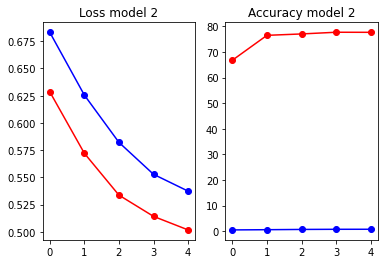

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Sequential(
  (0): Linear(in_features=768, out_features=64, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=64, out_features=32, bias=True)
  (4): ReLU()
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=32, out_features=2, bias=True)
)
Start training...

 Epoch  |  Batch  |  Train Loss  | F1 Train  |  Val Loss  |  Val Acc  |  F1 Val   |  Elapsed 
-----------------------------------------------------------------------------------------------
   1    |   20    |   0.693688   |   0.47    |     -      |     -     |     -     |   2.18   
   1    |   40    |   0.687586   |   0.49    |     -      |     -     |     -     |   2.08   
   1    |   60    |   0.681926   |   0.44    |     -      |     -     |     -     |   2.09   
   1    |   80    |   0.677273   |   0.43    |     -      |     -     |     -     |   2.10   
   1    |   100   |   0.677307   |   0.44    |     -      |     -     |     -     |   2.08   
   1    |   120   |   0.679295 

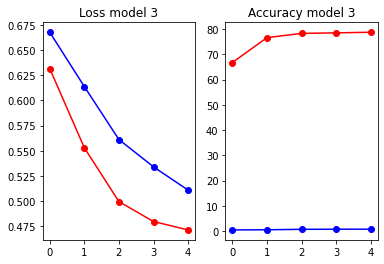

------RESULT------


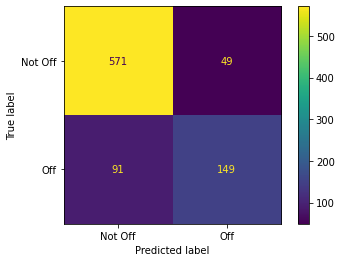

              precision    recall  f1-score   support

     Not Off     0.8625    0.9210    0.8908       620
         Off     0.7525    0.6208    0.6804       240

    accuracy                         0.8372       860
   macro avg     0.8075    0.7709    0.7856       860
weighted avg     0.8318    0.8372    0.8321       860

f1_score test tweets: 0.785580464314463


In [16]:
models, preds_ensemble = run_with_kfold(input_ids_train, attention_masks_train, test_dataloader, torch.tensor(label), label_test, H_PARAMETERS)

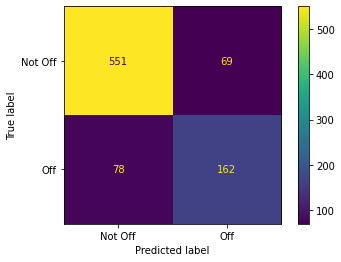

              precision    recall  f1-score   support

     Not Off     0.8760    0.8887    0.8823       620
         Off     0.7013    0.6750    0.6879       240

    accuracy                         0.8291       860
   macro avg     0.7886    0.7819    0.7851       860
weighted avg     0.8272    0.8291    0.8281       860

Bert model 0 tweets testset result => Loss: 0.4294348657131195 Accuracy: 82.90697674418604 F1 score: 78.51019669238575


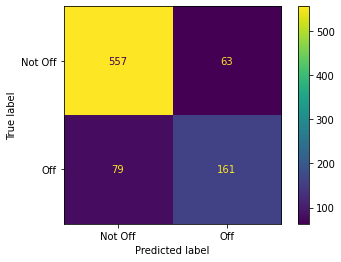

              precision    recall  f1-score   support

     Not Off     0.8758    0.8984    0.8869       620
         Off     0.7188    0.6708    0.6940       240

    accuracy                         0.8349       860
   macro avg     0.7973    0.7846    0.7905       860
weighted avg     0.8320    0.8349    0.8331       860

Bert model 1 tweets testset result => Loss: 0.42670929431915283 Accuracy: 83.48837209302326 F1 score: 79.04540962003075


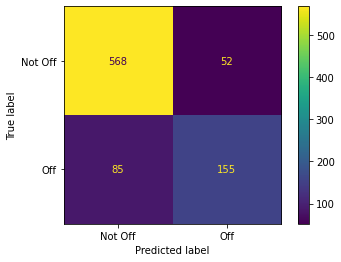

              precision    recall  f1-score   support

     Not Off     0.8698    0.9161    0.8924       620
         Off     0.7488    0.6458    0.6935       240

    accuracy                         0.8407       860
   macro avg     0.8093    0.7810    0.7929       860
weighted avg     0.8361    0.8407    0.8369       860

Bert model 2 tweets testset result => Loss: 0.4379971921443939 Accuracy: 84.06976744186046 F1 score: 79.29462542462538


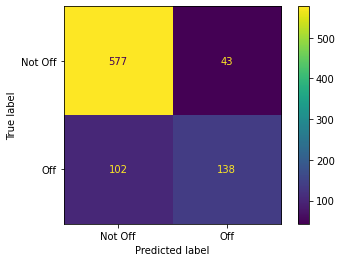

              precision    recall  f1-score   support

     Not Off     0.8498    0.9306    0.8884       620
         Off     0.7624    0.5750    0.6556       240

    accuracy                         0.8314       860
   macro avg     0.8061    0.7528    0.7720       860
weighted avg     0.8254    0.8314    0.8234       860

Bert model 3 tweets testset result => Loss: 0.4225834310054779 Accuracy: 83.13953488372093 F1 score: 77.19788106692704


In [17]:
for i in range(len(models)):
  models[i].to(device)
  val_loss, val_accuracys, f1_value_tweets = evaluateFinal(models[i], test_dataloader, H_PARAMETERS['device'], H_PARAMETERS['loss'])
  models[i].to('cpu')
  print("Bert model {0} tweets testset result => Loss: {1} Accuracy: {2} F1 score: {3}".format(i, val_loss, val_accuracys, f1_value_tweets))

In [18]:
showWrongPredictions(test_data, torch.tensor(label), preds_ensemble)

       id                   tweet
14  12588  user nigga ware da hit
       id                                   tweet
15  34263  stop kavanaugh liar like rest gop http
       id                                             tweet
26  69576  user school shoot controversial want gun control
       id                                              tweet
27  49139  user put delauro police lineup identify bag la...
       id                                              tweet
38  46444  ariana asesina serious holy shit please fuck a...
      id                                              tweet
1  27014  constitution day revere conservatives hat prog...
      id                                              tweet
3  13876  watch boomer get news still parole always make...
      id                                              tweet
6  96874  rap form art use express freely gv green light...
      id                                      tweet
7  65507  user get feel kiss behind humiliate later
    